<a href="https://colab.research.google.com/github/akkinasrikar/500-AI-Machine-learning-Deep-learning-Computer-vision-NLP-Projects-with-code/blob/main/imageseg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  61.7M      0  0:00:12  0:00:12 --:--:-- 62.3M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  41.8M      0 --:--:-- --:--:-- --:--:-- 41.9M


In [4]:
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.pyplot import imread
style.use('fivethirtyeight')
import numpy as np
import os

In [5]:
current_dir=os.getcwd()
current_dir

'/content'

In [6]:
os.listdir(current_dir)

['.config',
 'images.tar.gz',
 'annotations',
 'annotations.tar.gz',
 'images',
 'sample_data']

In [7]:
images_dir=os.path.join(current_dir,'images')

In [8]:
images_dir

'/content/images'

In [9]:
annotations_dir=os.path.join(current_dir,'annotations')
target_dir=os.path.join(annotations_dir,'trimaps')
target_dir

'/content/annotations/trimaps'

In [10]:
img_size = (160, 160)
num_classes = 3
batch_size = 32

In [11]:
def display_images(dir_):
    plt.figure(figsize=(19,12.5))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.grid(False)
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        rn=np.random.randint(0,len(os.listdir(dir_)))
        img_path=os.listdir(dir_)[rn]
        img_path=os.path.join(dir_,img_path)
        plt.imshow(imread(img_path))
    plt.show()


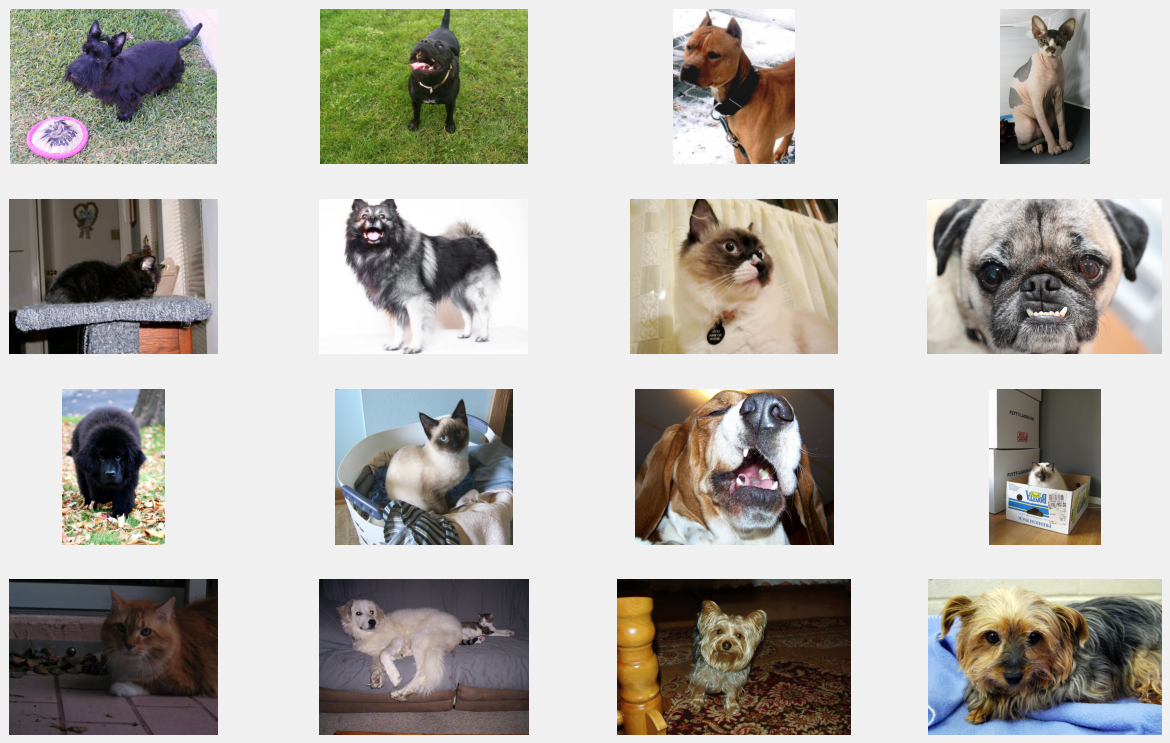

In [12]:
display_images(images_dir)

In [13]:
input_img_paths=sorted([
    os.path.join(images_dir,fname)
    for fname in os.listdir(images_dir)
    if fname.endswith(".jpg")
])

In [14]:
input_img_paths[0:5]

['/content/images/Abyssinian_1.jpg',
 '/content/images/Abyssinian_10.jpg',
 '/content/images/Abyssinian_100.jpg',
 '/content/images/Abyssinian_101.jpg',
 '/content/images/Abyssinian_102.jpg']

In [15]:
target_img_paths=sorted([
    os.path.join(target_dir,fname)
    for fname in os.listdir(target_dir)
    if fname.endswith(".png") and not fname.startswith(".")
])

In [16]:
target_img_paths[0:5]

['/content/annotations/trimaps/Abyssinian_1.png',
 '/content/annotations/trimaps/Abyssinian_10.png',
 '/content/annotations/trimaps/Abyssinian_100.png',
 '/content/annotations/trimaps/Abyssinian_101.png',
 '/content/annotations/trimaps/Abyssinian_102.png']

In [17]:
print("no of sample :",len(target_img_paths))

no of sample : 7390


In [18]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

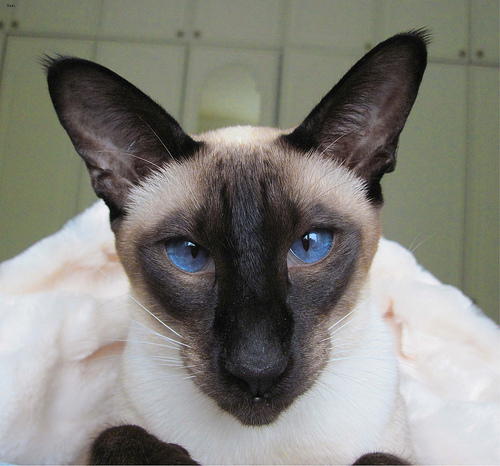

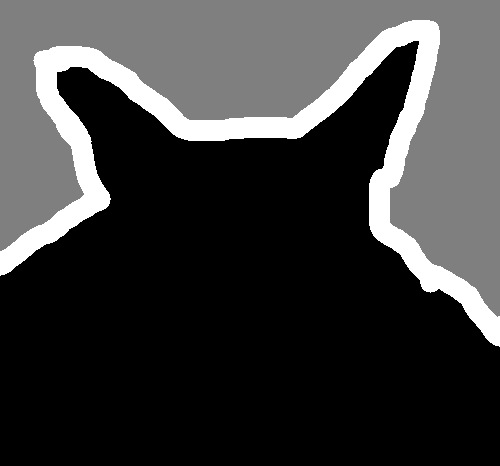

In [19]:
rn=np.random.randint(0,len(target_img_paths))
display(Image(filename=input_img_paths[rn]))
img=PIL.ImageOps.autocontrast(load_img(target_img_paths[rn]))
display(img)

In [20]:
from tensorflow import keras

In [21]:
class Oxfordpets(keras.utils.Sequence):
    
    def __init__(self,batch_size,img_size,input_img_paths,target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        
    #total no of batches
    def __len__(self):
        return len(self.target_img_paths)//self.batch_size
    
    #making the data into batches and return it to back
    def __getitem__(self,idx):
        i=idx*self.batch_size
        batch_input_image_paths=self.input_img_paths[i:i+self.batch_size]
        batch_target_image_paths=self.target_img_paths[i:i+self.batch_size]
        
        x=np.zeros((self.batch_size,)+self.img_size+(3,),dtype="uint8")
        for j,path in enumerate(batch_input_image_paths):
            img=load_img(path,target_size=img_size)
            x[j]=img
            
        y = np.zeros((self.batch_size,)+self.img_size+(1,),dtype="uint8")
        for j, path in enumerate(batch_target_image_paths):
            img = load_img(path, target_size=self.img_size,color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2
            y[j] -= 1
        return x, y

In [22]:
from tensorflow.keras import layers

In [23]:
def get_model(img_size,num_classes):
    
    inputs=keras.Input(shape=img_size+(3,))
    
    #downsampling half of networks
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    previous_block_activation = x
    
    # https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728
    for filters in [64,128,256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
                                 previous_block_activation)
        
        x=layers.add([x,residual]) #add back to residual
        
        previous_block_activation=x #reset the  previous_block_activation
        
    #now Upsampling
    
    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)
        
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual]) 
        previous_block_activation = x
        
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
    model = keras.Model(inputs, outputs)
    return model

In [24]:
keras.backend.clear_session()
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [25]:
import random

In [26]:
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

In [27]:
train_gen = Oxfordpets( batch_size, 
                        img_size, 
                        train_input_img_paths, 
                        train_target_img_paths)
val_gen = Oxfordpets(batch_size, 
                     img_size, 
                     val_input_img_paths, 
                     val_target_img_paths)


In [28]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
callbacks = [keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)]

In [29]:
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
199/199 [==============================] - 92s 400ms/step - loss: 1.6978 - val_loss: 1.9583
Epoch 2/15
199/199 [==============================] - 79s 397ms/step - loss: 0.5312 - val_loss: 2.0270
Epoch 3/15
199/199 [==============================] - 79s 398ms/step - loss: 0.4391 - val_loss: 0.4926
Epoch 4/15
199/199 [==============================] - 78s 393ms/step - loss: 0.3871 - val_loss: 0.5345
Epoch 5/15
199/199 [==============================] - 79s 398ms/step - loss: 0.3517 - val_loss: 0.4067
Epoch 6/15
199/199 [==============================] - 79s 397ms/step - loss: 0.3232 - val_loss: 0.4984
Epoch 7/15
199/199 [==============================] - 79s 398ms/step - loss: 0.2939 - val_loss: 0.4178
Epoch 8/15
199/199 [==============================] - 78s 393ms/step - loss: 0.2712 - val_loss: 0.4261
Epoch 9/15
199/199 [==============================] - 79s 396ms/step - loss: 0.2468 - val_loss: 0.3865
Epoch 10/15
199/199 [==============================] - 79s 397ms/step - l

In [30]:
from tensorflow.keras.models import model_from_json

In [31]:
model_json=model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

In [32]:
json_file=open("model.json","r")
loaded_model_json=json_file.read()
json_file.close()
loaded_model=model_from_json(loaded_model_json)
loaded_model.load_weights("model.h5")

In [33]:
val_gen = Oxfordpets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)

In [34]:
def display_mask(i):
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

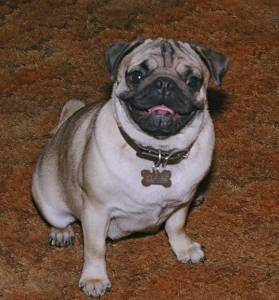

In [35]:
i=10
display(Image(filename=val_input_img_paths[i]))

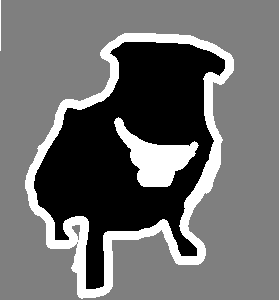

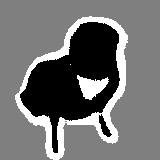

In [37]:
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)
display_mask(i)